### Scatterplot with color defined by a third list

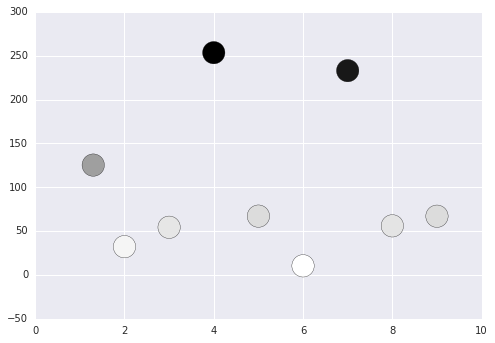

In [178]:
from matplotlib import pyplot as plt

x = [1.3, 2, 3, 4, 5, 6, 7, 8, 9]
y = [125.3, 32.23, 54.4, 253.5, 67.1, 10.4, 233, 56, 67]

color = [str(item/255.) for item in y]

plt.scatter(x, y, s=500, c=color)

plt.show()

## NNet classification


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import generate_data
import matplotlib.pyplot as plt
import numpy as np
import theano 
import theano.tensor as T
import pymc3 as pm

X, Y = generate_data.generate_1dlinear_data()
X_train = np.array(np.vstack((X,Y)).T,"float32")
del Y

In [2]:
Y_train = np.array( X_train[:,1] >= 3, dtype="int")

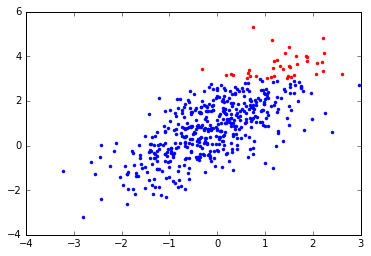

In [3]:
plt.plot(X_train[Y_train==0, 0],X_train[Y_train==0, 1], ".", color="blue")
plt.plot(X_train[Y_train==1, 0],X_train[Y_train==1, 1], ".", color="red")

#### Initialize mlp

- We will model $h(x) = p(y=1 \,\vert\, x)$ using the sigmoid at the output layer

### 1) Fit a model without bias

In [5]:
n_hidden = 5
input_dim = X_train.shape[1]
output_dim = 1
std_val = 0.5

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

n_hidden = 5

# Initialize random weights.
init_1 = np.random.randn(X_train.shape[1], n_hidden)
init_2 = np.random.randn(n_hidden, n_hidden)
init_out = np.random.randn(output_dim)

with pm.Model() as neural_network:
    
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=std_val , 
                             shape=(X_train.shape[1], n_hidden), 
                             testval=init_1)
    
    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=std_val , 
                            shape=(n_hidden, n_hidden), 
                            testval=init_2)
    
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=std_val , 
                              shape=(n_hidden,), 
                              testval=init_out)
    
    # Build neural-network
    act_1 = T.tanh(T.dot(ann_input, weights_in_1))
    act_2 = T.tanh(T.dot(act_1, weights_1_2))
    act_out = T.nnet.sigmoid(T.dot(act_2, weights_2_out))
    
    out = pm.Bernoulli('out', 
                       act_out,
                       observed=ann_output)


In [6]:
with neural_network:    
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step)

 [-----------------100%-----------------] 10000 of 10000 complete in 13.9 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0782b30278>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f078261a1d0>]], dtype=object)

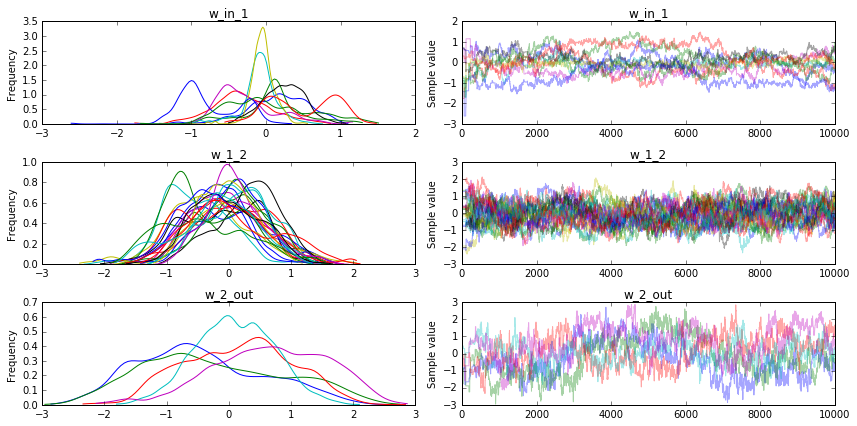

In [7]:
pm.traceplot(trace)

### predict train data

In [8]:
# Replace shared variables with testing set
# (note that using this trick we could be streaming ADVI for big data)
ann_input.set_value(X_train)
ann_output.set_value(Y_train)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace,
                    model=neural_network, 
                    samples=2000)

In [9]:
Y_train_pred = ppc['out'].mean(axis=0) > 0.6
print('Accuracy = {}%'.format((Y_train == Y_train_pred).mean() * 100))

Accuracy = 82.19999999999999%


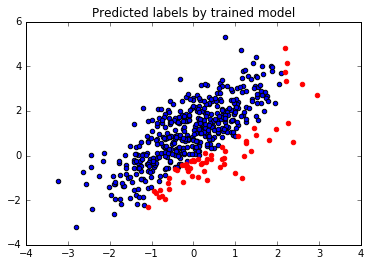

In [10]:
plt.scatter(X_train[Y_train_pred==0, 0], X_train[Y_train_pred==0, 1])
plt.scatter(X_train[Y_train_pred==1, 0], X_train[Y_train_pred==1, 1], color='r')
plt.title('Predicted labels by trained model')

#### Probability regions

- Matplotlib scatterplot; colour as a function of a third variable: http://stackoverflow.com/questions/8202605/matplotlib-scatterplot-colour-as-a-function-of-a-third-variable

In [69]:
h = 0.2

#x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
#x2_min, x2_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

x1_min, x1_max = -4, 4
x2_min, x2_max = -4, 4

x1_grid, x2_grid = np.meshgrid(np.arange(x1_min, x1_max, h),
                               np.arange(x2_min, x2_max, h))

grid_2d = np.array(np.c_[x1_grid.ravel(), x2_grid.ravel()], dtype="float32")

In [83]:
grid_2d.shape

(1600, 2)

In [70]:
dummy_out = np.ones(grid_2d.shape[1], dtype=np.int8)

ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

ppc = pm.sample_ppc(trace,
                    model=neural_network, 
                    samples=2000)

In [72]:
ppc['out'].shape

(2000, 1600)

In [85]:
ppc['out'].mean(axis=0).shape

(1600,)

In [86]:
predictions = ppc['out'].mean(axis=0)

In [79]:
width = np.sqrt(1600)
width

40.0

In [113]:
X_train.shape

(500, 2)

In [97]:
predictions.reshape((40,40))

array([[ 0.306 ,  0.312 ,  0.2975, ...,  0.948 ,  0.95  ,  0.947 ],
       [ 0.3045,  0.277 ,  0.31  , ...,  0.9435,  0.949 ,  0.9485],
       [ 0.294 ,  0.287 ,  0.2955, ...,  0.9405,  0.9415,  0.947 ],
       ..., 
       [ 0.057 ,  0.0535,  0.0525, ...,  0.694 ,  0.6955,  0.706 ],
       [ 0.044 ,  0.053 ,  0.0545, ...,  0.695 ,  0.7095,  0.693 ],
       [ 0.0475,  0.057 ,  0.057 , ...,  0.696 ,  0.7015,  0.723 ]])

In [126]:
grid_2d.shape, predictions.shape

((1600, 2), (1600,))

In [141]:
max(predictions*100)

95.899999999999991

In [168]:
colors = np.array([p for p in predictions])


In [169]:
colors.max()

0.95899999999999996

In [170]:
lsitgrid_2d[:,0]

array([-4.        , -3.79999995, -3.5999999 , ...,  3.4000001 ,
        3.5999999 ,  3.79999995], dtype=float32)

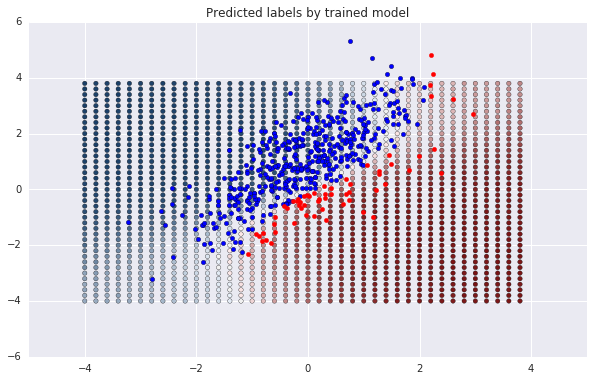

In [177]:
import seaborn as sns
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))

colors = np.array([p for p in predictions])

plt.scatter(grid_2d[:,0],
            grid_2d[:,1], 
            c =colors,
            cmap =cmap)

plt.scatter(X_train[Y_train_pred==0, 0], X_train[Y_train_pred==0, 1])
plt.scatter(X_train[Y_train_pred==1, 0], X_train[Y_train_pred==1, 1], color='r')
plt.title('Predicted labels by trained model')

#### Decision boundary

For this, we evaluate the class probability predictions on a grid over the whole input space.

In [ ]:
grid = np.mgrid[-4:4:200j,-4:4:200j]
grid_2d = np.array(grid.reshape(2, -1).T, dtype="float32")
X, Y = grid
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [ ]:
grid_2d.

In [ ]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=1000)

In [ ]:
Y.shape

In [ ]:
ppc['out'].mean(axis=0).shape

In [ ]:
X.shape

### 2) Fit a model with bias

In [ ]:
n_hidden = 5
input_dim = X_train.shape[1]
output_dim = 1
std_val = 0.5

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

# Initialize random weights between each layer
init_w1 = np.random.randn(input_dim , n_hidden)
init_b1 = np.random.randn(n_hidden)

init_w2 = np.random.randn(n_hidden, output_dim)
init_b2 = np.random.randn(output_dim )

In [ ]:
import theano
import theano.tensor as T
import pymc3
import pymc3 as pm

mlp_bias = pymc3.Model()


ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)


with mlp_bias:
    #######################################
    # Prior distributions over parameters #
    #######################################
    

    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_0_1', 0, sd=std_val, 
                             shape=(input_dim , n_hidden), 
                             testval=init_w1)
    
    bias_in_1 =  pm.Normal('b_1', 0, sd=std_val, 
                           shape= (n_hidden,), 
                           testval=init_b1)
            
    # Weights from 1st to 2nd (output) layer
    weights_1_out = pm.Normal('w_1_2', 0, sd=std_val, 
                              shape=(n_hidden,1 ), 
                              testval=init_w2)
    
    bias_in_2 =  pm.Normal('b_2', 0, sd=std_val, 
                           shape= (output_dim,), 
                           testval=init_b2)
        
    ####################
    # Model definition #
    ####################
    
    # Expected value of outcome
    act_1 = T.nnet.sigmoid(T.dot(ann_input, weights_in_1) + bias_in_1)
    act_out = T.nnet.sigmoid(T.dot(act_1, weights_1_out) + bias_in_2)
  
    out = pm.Bernoulli('out', 
                       act_out,
                       observed=ann_output)

In [ ]:
with mlp:    
    step = pm.Metropolis()
    trace = pm.sample(100000, step=step)[5000:]

### predict train data

In [ ]:
# Replace shared variables with testing set
# (note that using this trick we could be streaming ADVI for big data)
ann_input.set_value(X_train)
ann_output.set_value(Y_train)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace,
                    model=neural_network, 
                    samples=1000)

In [ ]:
Y_train_pred = ppc['out'].mean(axis=0) > 0.6
print('Accuracy = {}%'.format((Y_train == Y_train_pred).mean() * 100))

In [ ]:
plt.scatter(X_train[Y_train_pred==0, 0], X_train[Y_train_pred==0, 1])
plt.scatter(X_train[Y_train_pred==1, 0], X_train[Y_train_pred==1, 1], color='r')
plt.title('Predicted labels by trained model')

### Plot probability regions

In [ ]:
prob_regions = [0.5,0.6,0.7]

In [ ]:
h = 0.2
x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
x2_min, x2_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

x1_grid, x2_grid = np.meshgrid(np.arange(x1_min, x1_max, h),
                               np.arange(x2_min, x2_max, h))

grid = np.array(np.c_[x1_grid.ravel(), x2_grid.ravel()], dtype="float32")

In [ ]:
grid = np.array(np.c_[x1_grid.ravel(), x2_grid.ravel()], dtype="float32")

In [ ]:
trace.varnames

### Contour plot

In [ ]:
trace.varnames

In [ ]:
sym_input = T.matrix("sym_input")

# Defined shared variables of the model
sha_W1 = theano.shared(trace["w_0_1"].mean(axis=0))
sha_W2 = theano.shared(trace["w_1_2"].mean(axis=0))
sha_b1 = theano.shared(trace["b_1"].mean(axis=0))
sha_b2 = theano.shared(trace["b_2"].mean(axis=0))

act_1 = T.nnet.sigmoid(T.dot(ann_input, weights_in_1) + bias_in_1)
act_out = T.nnet.sigmoid(T.dot(act_1, weights_1_out) + bias_in_2)
    
predict = theano.function([sym_input],act_out)